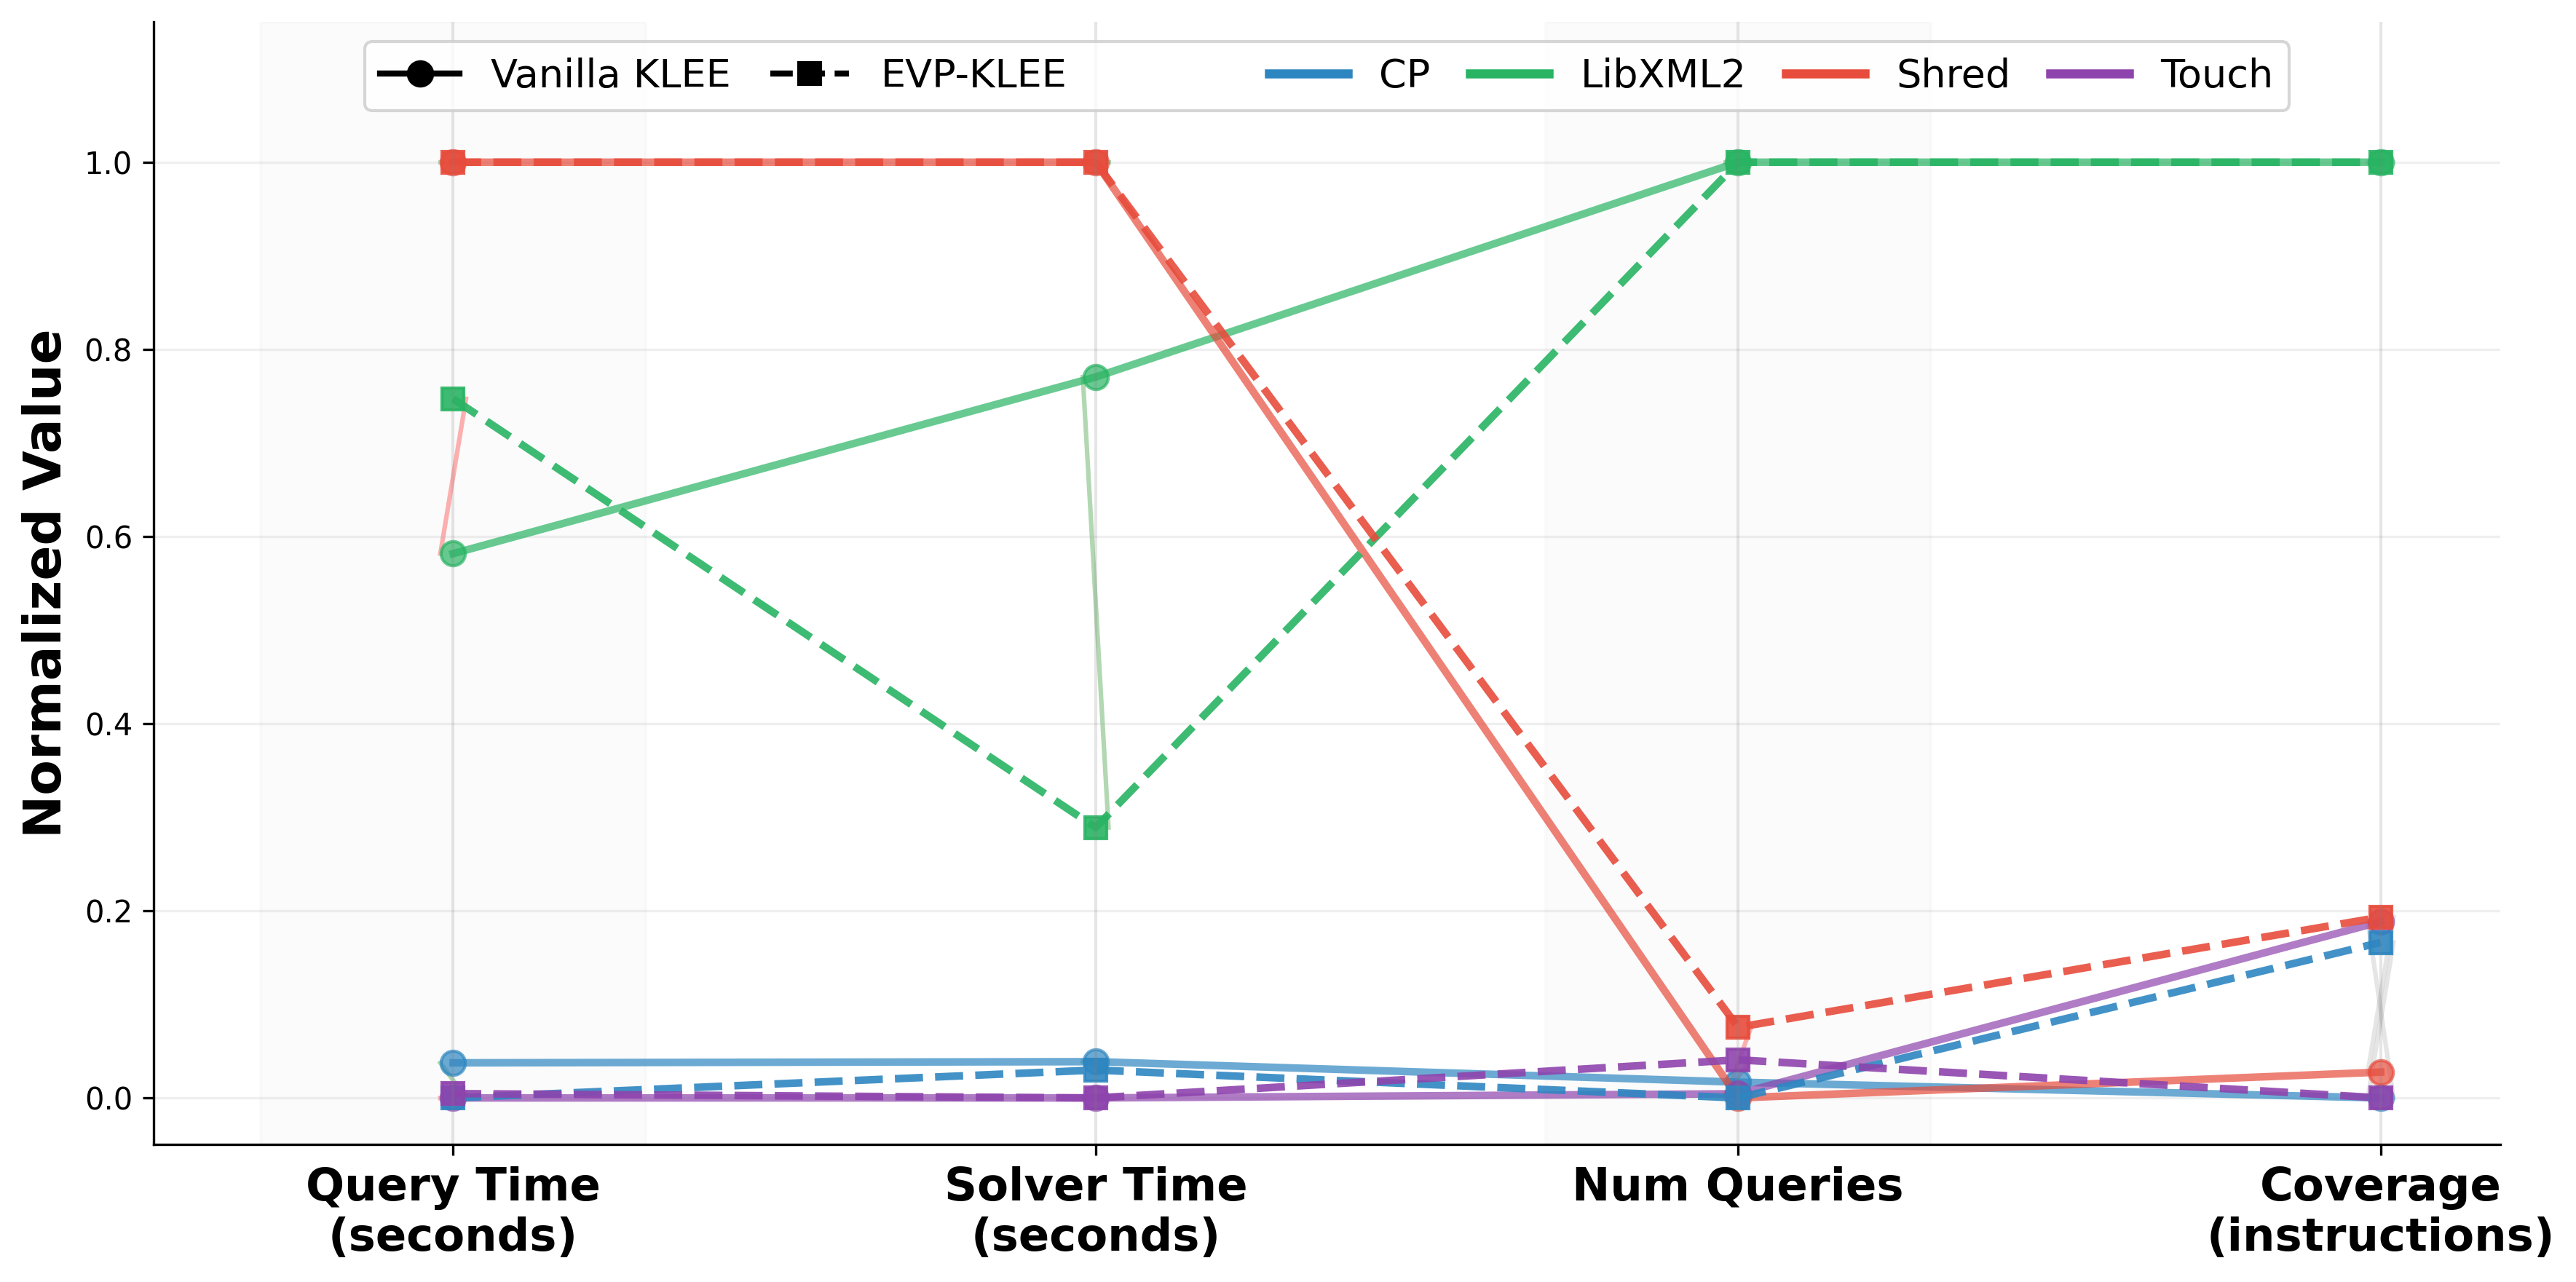

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Set publication quality parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42

# Updated data from your table
programs = ['cp', 'libxml2', 'shred', 'touch']
vanilla_query = np.array([144420.3, 1230908.97, 2066126.62, 69508.47])
evp_query = np.array([164767.01, 1580302.24, 2059401.52, 173567.7])
vanilla_solver = np.array([159308.86, 1619780.82, 2078041.25, 81929.11])
evp_solver = np.array([63895.7, 513460.41, 1746889.82, 12159.08])
vanilla_queries = np.array([8040, 85869, 6704, 7057])
evp_queries = np.array([12792, 169081, 24591, 19157])
coverage_vanilla = np.array([8484, 16711, 8711, 10034])
coverage_evp = np.array([8360, 14841, 8570, 7068])

# Calculate improvements
query_improvement = ((vanilla_query - evp_query) / vanilla_query) * 100
solver_improvement = ((vanilla_solver - evp_solver) / vanilla_solver) * 100
queries_change = ((vanilla_queries - evp_queries) / vanilla_queries) * 100

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize data for parallel coordinates (0-1 scale)
def normalize(data):
    return (data - data.min()) / (data.max() - data.min()) if data.max() != data.min() else data

# Prepare data for parallel coordinates
x_labels = ['Query Time\n(seconds)', 'Solver Time\n(seconds)', 'Num Queries', 'Coverage\n(instructions)']
x_positions = np.array([0, 1, 2, 3])

# Colors for each program (professional palette)
colors = {
    'cp': '#2E86C1',      # Blue
    'libxml2': '#28B463', # Green
    'shred': '#E74C3C',   # Red
    'touch': '#8E44AD'    # Purple
}

# Plot lines for Vanilla KLEE (solid lines)
for i, prog in enumerate(programs):
    # Normalize values
    norm_query = normalize(vanilla_query)[i]
    norm_solver = normalize(vanilla_solver)[i]
    norm_queries = normalize(vanilla_queries)[i]
    norm_coverage = normalize(coverage_vanilla)[i]

    y_vanilla = [norm_query, norm_solver, norm_queries, norm_coverage]

    # Plot vanilla line
    ax.plot(x_positions, y_vanilla, 'o-',
            color=colors[prog], linewidth=2.5, markersize=8,
            alpha=0.7, label=f'{prog} (Vanilla)')

# Plot lines for EVP KLEE (dashed lines)
for i, prog in enumerate(programs):
    # Normalize values
    norm_query = normalize(evp_query)[i]
    norm_solver = normalize(evp_solver)[i]
    norm_queries = normalize(evp_queries)[i]
    norm_coverage = normalize(coverage_evp)[i]

    y_evp = [norm_query, norm_solver, norm_queries, norm_coverage]

    # Plot EVP line
    ax.plot(x_positions, y_evp, 's--',
            color=colors[prog], linewidth=2.5, markersize=7,
            alpha=0.9, label=f'{prog} (EVP)')

    # Connect vanilla to EVP with a thin gray line for the same program
    y_vanilla = [normalize(vanilla_query)[i], normalize(vanilla_solver)[i],
                 normalize(vanilla_queries)[i], normalize(coverage_vanilla)[i]]
    for j in range(len(x_positions)):
        # Color code the connection based on improvement
        if j == 1:  # Solver time (where EVP generally improves)
            conn_color = 'green'
            conn_alpha = 0.3
        elif j in [0, 2]:  # Query time and num queries (where EVP often performs worse)
            conn_color = 'red' if y_evp[j] > y_vanilla[j] else 'green'
            conn_alpha = 0.3
        else:
            conn_color = 'gray'
            conn_alpha = 0.2

        ax.plot([x_positions[j]-0.02, x_positions[j]+0.02],
                [y_vanilla[j], y_evp[j]],
                color=conn_color, linewidth=1.5, alpha=conn_alpha, zorder=0)

# Styling
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels, fontweight='bold')
ax.set_ylim(-0.05, 1.15)
ax.set_ylabel('Normalized Value', fontweight='bold', fontsize=17)

# Add grid
for x in x_positions:
    ax.axvline(x, color='gray', alpha=0.2, linestyle='-', linewidth=1)
ax.grid(True, axis='y', alpha=0.2)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add background shading for each metric
for i, x in enumerate(x_positions):
    if i % 2 == 0:
        ax.axvspan(x-0.3, x+0.3, alpha=0.03, color='gray', zorder=-1)

# Create legend
legend_elements = [
    Line2D([0], [0], color='black', linestyle='-', marker='o',
           markersize=8, label='Vanilla KLEE', linewidth=2),
    Line2D([0], [0], color='black', linestyle='--', marker='s',
           markersize=7, label='EVP-KLEE', linewidth=2),
    Line2D([0], [0], color='white', linestyle='-', marker='o',
           markersize=0, label=' '),  # Spacer
    Line2D([0], [0], color=colors['cp'], linestyle='-',
           linewidth=3, label='CP'),
    Line2D([0], [0], color=colors['libxml2'], linestyle='-',
           linewidth=3, label='LibXML2'),
    Line2D([0], [0], color=colors['shred'], linestyle='-',
           linewidth=3, label='Shred'),
    Line2D([0], [0], color=colors['touch'], linestyle='-',
           linewidth=3, label='Touch'),
]

ax.legend(handles=legend_elements, loc='upper center',
         bbox_to_anchor=(0.5, 1.00),
         frameon=True, fancybox=True, shadow=False,
         ncol=7, columnspacing=1, handlelength=2)

# Add summary statistics with mixed performance indication
avg_solver_impr = np.mean(solver_improvement)
avg_query_change = np.mean(query_improvement)

# stats_text = f"Solver Time Reduction: {avg_solver_impr:.1f}%\n"
# if avg_query_change < 0:
#     stats_text += f"Query Time Increase: {abs(avg_query_change):.1f}%\n"
# else:
#     stats_text += f"Query Time Reduction: {avg_query_change:.1f}%\n"
# stats_text += f"Trade-off: Better solver performance\nvs. more queries"

# props = dict(boxstyle='round,pad=0.5', facecolor='#F8F9F9',
#             edgecolor='#BDC3C7', alpha=0.95, linewidth=1)
# ax.text(0.98, 0.35, stats_text, transform=ax.transAxes,
#         fontsize=10, verticalalignment='top',
#         horizontalalignment='right', bbox=props)

plt.tight_layout()

# Save figure
plt.savefig('rq1-parallel-coordinates-new.pdf', dpi=300, bbox_inches='tight')
plt.savefig('rq1-parallel-coordinates-new.png', dpi=300, bbox_inches='tight')
plt.show()


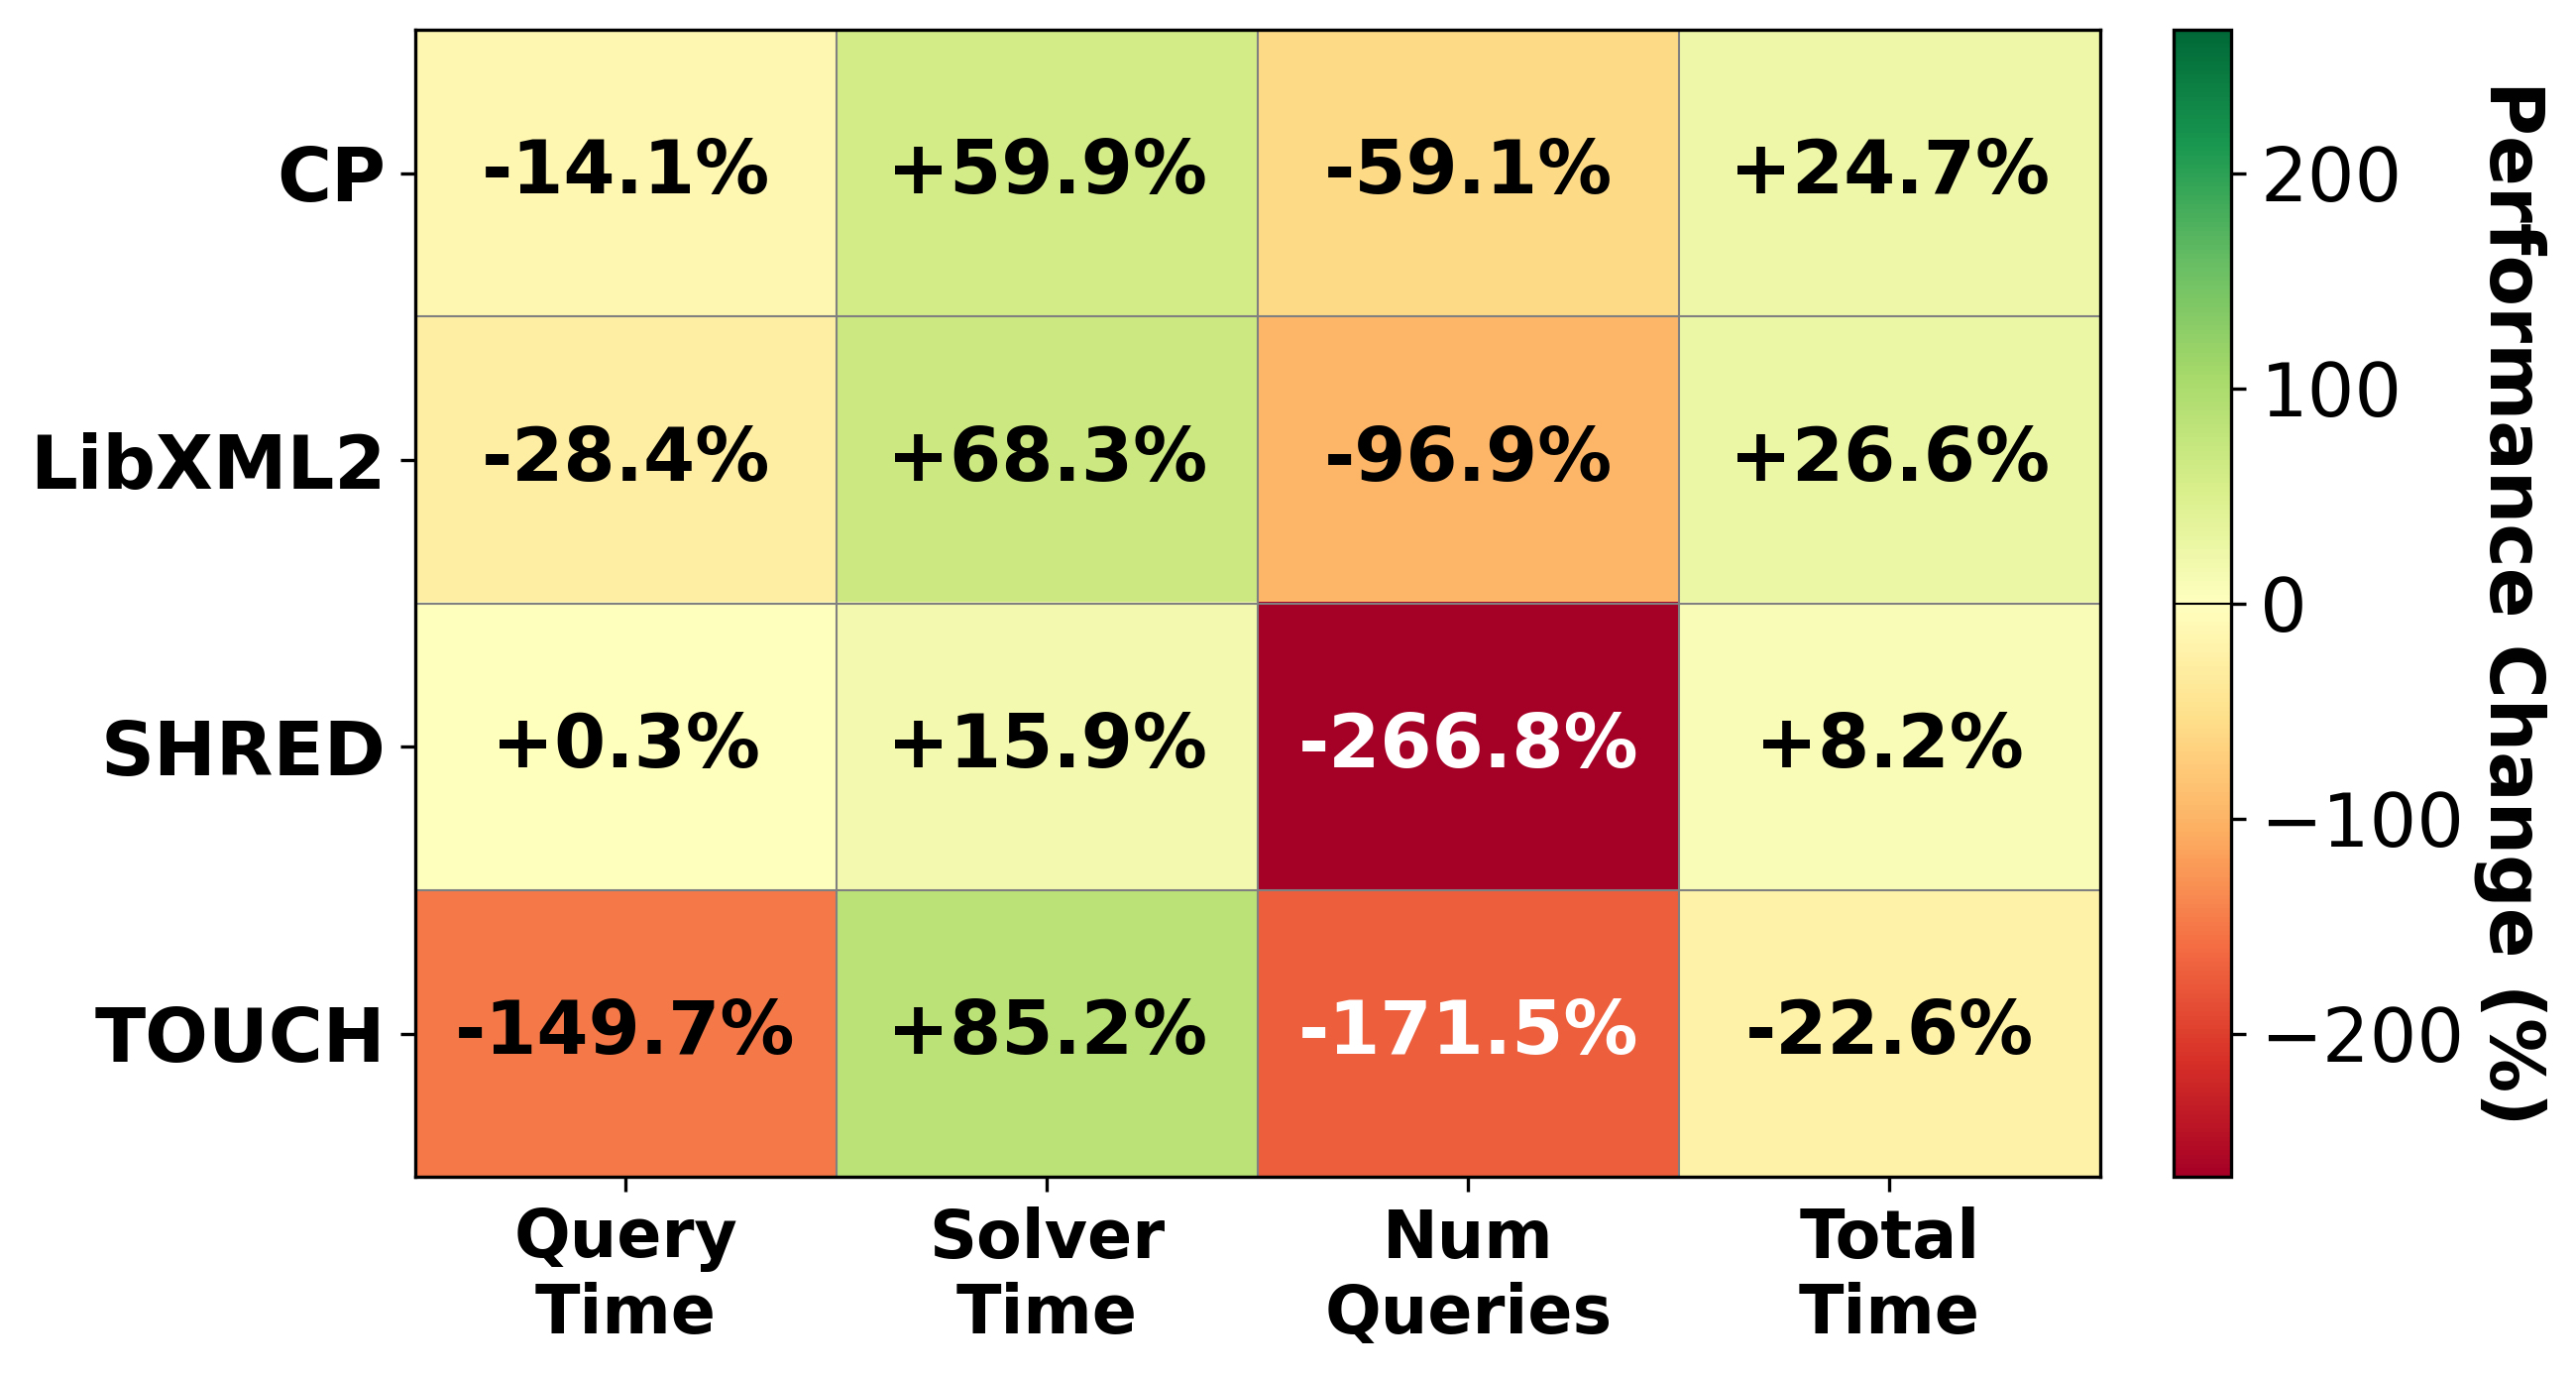


PERFORMANCE ANALYSIS SUMMARY

=== Query Time Changes ===
cp      :  -14.1% ↑ Worse
libxml2 :  -28.4% ↑ Worse
shred   :   +0.3% ↓ Better
touch   : -149.7% ↑ Worse

=== Solver Time Improvements ===
cp      :  +59.9% ↓ Better
libxml2 :  +68.3% ↓ Better
shred   :  +15.9% ↓ Better
touch   :  +85.2% ↓ Better

=== Number of Queries Changes ===
cp      :  -59.1% ↑ More
libxml2 :  -96.9% ↑ More
shred   : -266.8% ↑ More
touch   : -171.5% ↑ More

=== Total Time Improvements ===
cp      :  +24.7% ↓ Better
libxml2 :  +26.6% ↓ Better
shred   :   +8.2% ↓ Better
touch   :  -22.6% ↑ Worse

=== Overall Statistics ===
Average Solver Time Improvement: +57.3%
Average Query Time Change: -48.0%
Average Total Time Improvement: +9.2%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set publication quality parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 19
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 19
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42

# Updated data
programs = ['cp', 'libxml2', 'shred', 'touch']
vanilla_query = np.array([144420.3, 1230908.97, 2066126.62, 69508.47])
evp_query = np.array([164767.01, 1580302.24, 2059401.52, 173567.7])
vanilla_solver = np.array([159308.86, 1619780.82, 2078041.25, 81929.11])
evp_solver = np.array([63895.7, 513460.41, 1746889.82, 12159.08])
vanilla_queries = np.array([8040, 85869, 6704, 7057])
evp_queries = np.array([12792, 169081, 24591, 19157])

# Calculate improvements (positive means EVP is better)
query_improvement = ((vanilla_query - evp_query) / vanilla_query) * 100
solver_improvement = ((vanilla_solver - evp_solver) / vanilla_solver) * 100
queries_change = ((vanilla_queries - evp_queries) / vanilla_queries) * 100

# Calculate Total Time improvement
vanilla_total = vanilla_query + vanilla_solver
evp_total = evp_query + evp_solver
total_improvement = ((vanilla_total - evp_total) / vanilla_total) * 100

# Create figure with adjusted width for 4 metrics
fig, ax = plt.subplots(figsize=(9, 5))

# Create improvement matrix with 4 columns
improvements = np.array([query_improvement, solver_improvement, queries_change, total_improvement]).T

# Use a diverging colormap centered at 0 to show both improvements and regressions
# Positive values (green) = improvement, Negative values (red) = regression
vmax = max(abs(improvements.min()), abs(improvements.max()))
im = ax.imshow(improvements, cmap='RdYlGn', vmin=-vmax, vmax=vmax, aspect='auto')

# Add text annotations
for i in range(len(programs)):
    for j in range(4):
        value = improvements[i, j]
        # Choose text color based on background
        text_color = 'white' if abs(value) > vmax * 0.6 else 'black'

        # Format text with + or - sign
        if value > 0:
            text = f'+{value:.1f}%'
        else:
            text = f'{value:.1f}%'

        ax.text(j, i, text,
                ha="center", va="center", color=text_color,
                fontweight='bold', fontsize=18)

# Styling with 4 columns
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['Query\nTime', 'Solver\nTime', 'Num\nQueries', 'Total\nTime'], fontweight='bold')
ax.set_yticks(np.arange(len(programs)))
ax.set_yticklabels([p.upper() if p != 'libxml2' else 'LibXML2' for p in programs], fontweight='bold')

# Add colorbar with centered labels
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Performance Change (%)', rotation=270, labelpad=20, fontweight='bold')

# Add reference lines at 0 for clarity
cbar.ax.axhline(y=0, color='black', linewidth=0.5)

# Add grid for clarity
ax.set_xticks(np.arange(4) - 0.5, minor=True)
ax.set_yticks(np.arange(len(programs)) - 0.5, minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", size=0)

# # Add title to explain the color scheme
# ax.set_title('EVP Performance Impact (Green=Better, Red=Worse)',
#             fontsize=14, fontweight='bold', pad=10)

plt.tight_layout()

# Save figure
plt.savefig('rq1-improvement-heatmap-new.pdf', dpi=300, bbox_inches='tight')
plt.savefig('rq1-improvement-heatmap-new.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("PERFORMANCE ANALYSIS SUMMARY")
print("="*60)

print("\n=== Query Time Changes ===")
for i, prog in enumerate(programs):
    status = "↓ Better" if query_improvement[i] > 0 else "↑ Worse"
    print(f"{prog:8}: {query_improvement[i]:+6.1f}% {status}")

print("\n=== Solver Time Improvements ===")
for i, prog in enumerate(programs):
    status = "↓ Better" if solver_improvement[i] > 0 else "↑ Worse"
    print(f"{prog:8}: {solver_improvement[i]:+6.1f}% {status}")

print("\n=== Number of Queries Changes ===")
for i, prog in enumerate(programs):
    status = "↓ Fewer" if queries_change[i] > 0 else "↑ More"
    print(f"{prog:8}: {queries_change[i]:+6.1f}% {status}")

print("\n=== Total Time Improvements ===")
for i, prog in enumerate(programs):
    status = "↓ Better" if total_improvement[i] > 0 else "↑ Worse"
    print(f"{prog:8}: {total_improvement[i]:+6.1f}% {status}")

print("\n=== Overall Statistics ===")
print(f"Average Solver Time Improvement: {np.mean(solver_improvement):+.1f}%")
print(f"Average Query Time Change: {np.mean(query_improvement):+.1f}%")
print(f"Average Total Time Improvement: {np.mean(total_improvement):+.1f}%")


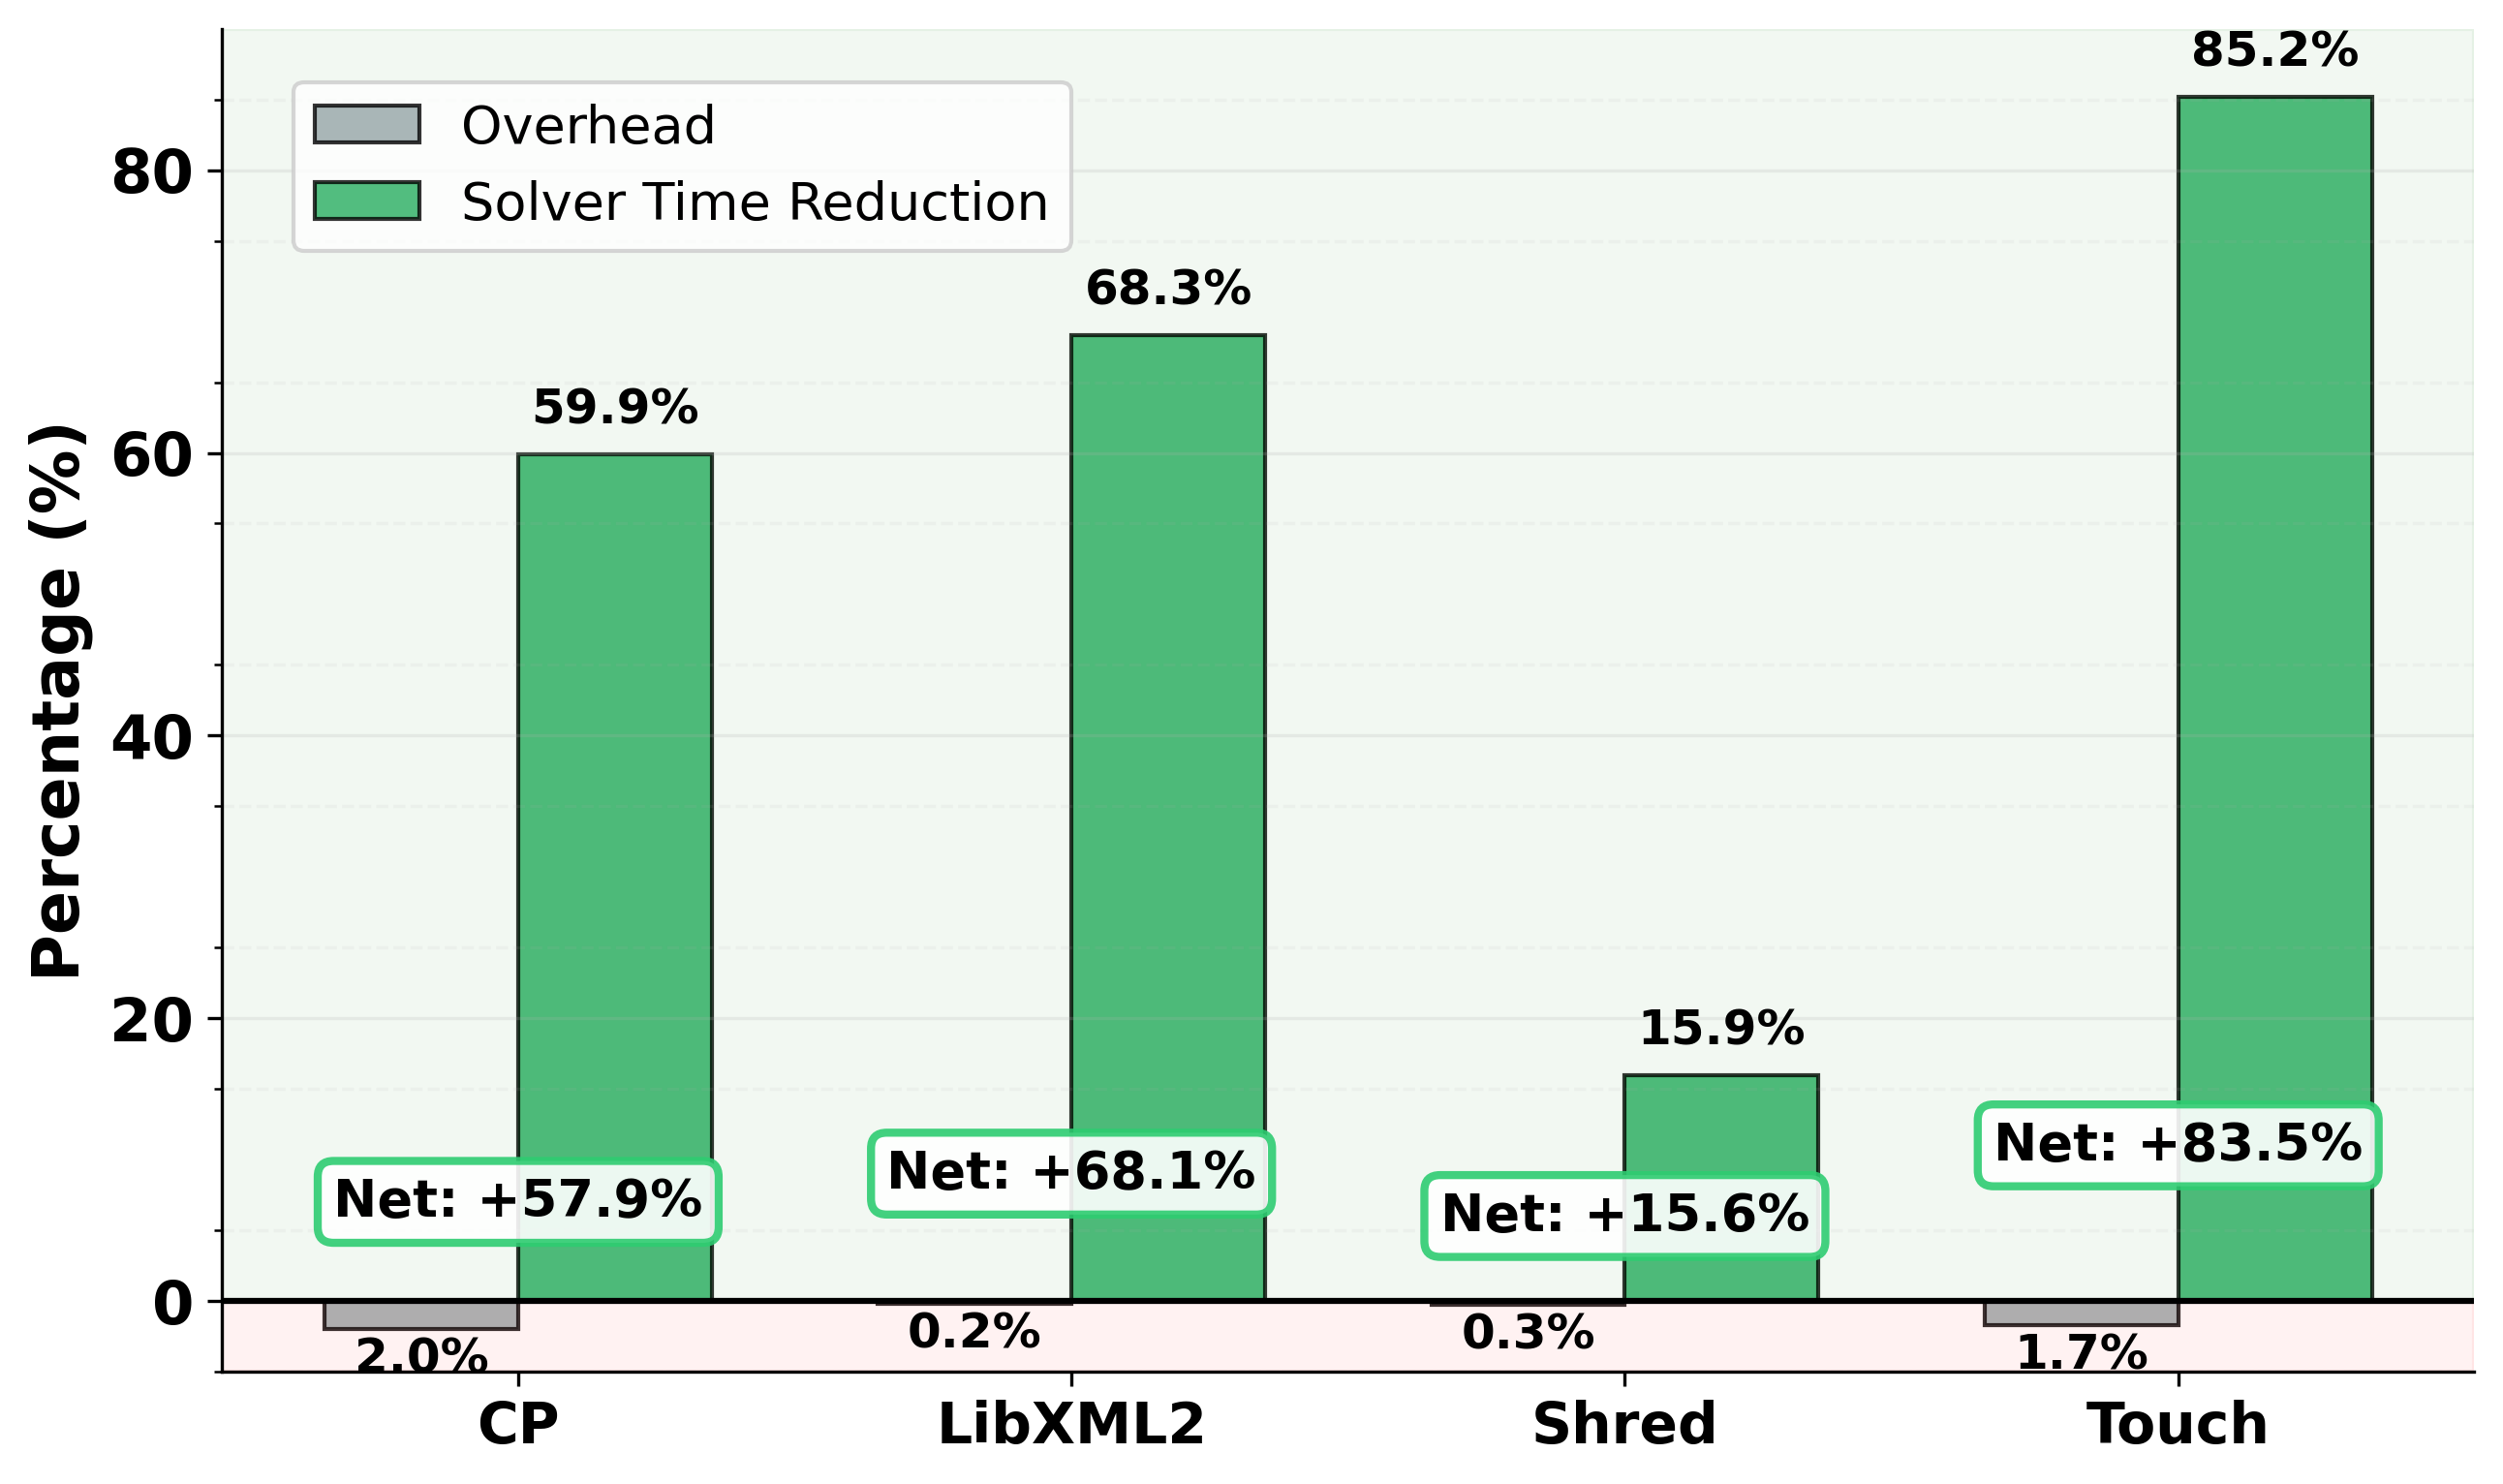


RQ2: OVERHEAD ANALYSIS SUMMARY

=== Overhead Breakdown ===
CP      :   2.0% overhead
LibXML2 :   0.2% overhead
Shred   :   0.3% overhead
Touch   :   1.7% overhead

=== Solver Performance Gains ===
CP      :  59.9% improvement
LibXML2 :  68.3% improvement
Shred   :  15.9% improvement
Touch   :  85.2% improvement

=== Net Benefits (Solver Improvement - Overhead) ===
CP      : + 57.9% net benefit
LibXML2 : + 68.1% net benefit
Shred   : + 15.6% net benefit
Touch   : + 83.5% net benefit

=== Overall Statistics ===
Average Overhead: 1.05%
Min Overhead: 0.20% (LibXML2)
Max Overhead: 2.00% (CP)
Average Solver Improvement: 57.3%
Average Net Benefit: 56.3%
All programs show positive net benefit: True

=== Overhead Components (from data) ===

CP:
  Instrument:  1072.2s (30.1%)
  Profile:     1478.6s (41.5%)
  Analyze:     1009.2s (28.3%)
  Total:       3560.0s

LibXML2:
  Instrument:  1121.2s (35.8%)
  Profile:     1006.0s (32.1%)
  Analyze:     1004.2s (32.1%)
  Total:       3131.4s

Shred:
  I

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set publication quality parameters with INCREASED FONT SIZES
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 17
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42

# Data from your overhead table
programs = ['CP', 'LibXML2', 'Shred', 'Touch']
overhead_percentages = np.array([2.0, 0.2, 0.3, 1.7])

# Calculate total time improvements from the performance data
# Using the formula: ((vanilla_total - evp_total) / vanilla_total) * 100
vanilla_query = np.array([144420.3, 1230908.97, 2066126.62, 69508.47])
evp_query = np.array([164767.01, 1580302.24, 2059401.52, 173567.7])
vanilla_solver = np.array([159308.86, 1619780.82, 2078041.25, 81929.11])
evp_solver = np.array([63895.7, 513460.41, 1746889.82, 12159.08])

# Calculate total times and improvements
vanilla_total = vanilla_query + vanilla_solver
evp_total = evp_query + evp_solver
total_improvements = ((vanilla_total - evp_total) / vanilla_total) * 100

# For display, we'll use solver improvements since they're consistently positive
solver_improvements = ((vanilla_solver - evp_solver) / vanilla_solver) * 100

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Colors (professional palette)
colors = {
    'overhead': '#95A5A6',    # Gray
    'improvement': '#27AE60'   # Green
}

# Create grouped bar chart
x = np.arange(len(programs))
width = 0.35

# Plot overhead (negative) and improvement (positive)
bars1 = ax.bar(x - width/2, -overhead_percentages, width,
                label='Overhead', color=colors['overhead'],
                edgecolor='black', linewidth=1, alpha=0.8)
bars2 = ax.bar(x + width/2, solver_improvements, width,
                label='Solver Time Reduction', color=colors['improvement'],
                edgecolor='black', linewidth=1, alpha=0.8)

# Add value labels with LARGER FONTS
for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    # Overhead label - MOVED UP to avoid x-axis overlap
    ax.text(bar1.get_x() + bar1.get_width()/2,
            -overhead_percentages[i] - 0.5,  # Changed from -1.5 to -0.5
            f'{overhead_percentages[i]:.1f}%',
            ha='center', va='top', fontweight='bold', fontsize=12)

    # Improvement label
    ax.text(bar2.get_x() + bar2.get_width()/2,
            solver_improvements[i] + 1.5,
            f'{solver_improvements[i]:.1f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

    # Net benefit annotation (using solver improvement - overhead)
    net_benefit = solver_improvements[i] - overhead_percentages[i]

    # Position net benefit label higher to avoid overlap
    # Use staggered heights for better visibility
    if programs[i] == 'CP':
        y_pos = 7
    elif programs[i] == 'LibXML2':
        y_pos = 9  # Slightly higher since it has a tall bar
    elif programs[i] == 'Shred':
        y_pos = 6
    else:  # Touch
        y_pos = 11  # Higher because of its very tall improvement bar

    ax.text(x[i], y_pos, f'Net: +{net_benefit:.1f}%',
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                     edgecolor='#2ECC71' if net_benefit > 0 else 'gray',
                     alpha=0.9, linewidth=2),
            fontsize=13, fontweight='bold')

# Styling with LARGER Y-AXIS LABELS
ax.set_ylabel('Percentage (%)', fontweight='bold', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(programs, fontweight='bold', fontsize=14)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax.set_ylim(-5, 90)

# MAKE Y-AXIS TICK LABELS BOLD AND LARGER
y_ticks = [0, 20, 40, 60, 80]
ax.set_yticks(y_ticks)
y_labels = [f'{int(y)}' for y in y_ticks]
ax.set_yticklabels(y_labels, fontweight='bold', fontsize=15)

# Add minor gridlines
ax.set_yticks(np.arange(-5, 90, 10), minor=True)
ax.grid(True, axis='y', alpha=0.2, linestyle='-', which='major')
ax.grid(True, axis='y', alpha=0.1, linestyle='--', which='minor')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add shaded regions (subtle)
ax.axhspan(-5, 0, alpha=0.05, color='red', label='_nolegend_')
ax.axhspan(0, 90, alpha=0.05, color='green', label='_nolegend_')

# Move legend to upper left since values are high on the right
ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
          frameon=True, fancybox=True, shadow=False, ncol=1,
          fontsize=13)

# # Add a text box with key findings
# key_findings = "Key Findings:\n• Minimal overhead (avg. 1.1%)\n• Significant solver improvements\n• All programs show net benefit"
# props = dict(boxstyle='round,pad=0.5', facecolor='#F8F9F9',
#             edgecolor='#BDC3C7', alpha=0.95, linewidth=1)
# ax.text(0.98, 0.5, key_findings, transform=ax.transAxes,
#         fontsize=11, verticalalignment='center',
#         horizontalalignment='right', bbox=props)

# plt.tight_layout()

# Save figures
plt.savefig('rq2-overhead-benefit-new.pdf', dpi=300, bbox_inches='tight')
plt.savefig('rq2-overhead-benefit-new.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed summary statistics
print("\n" + "="*60)
print("RQ2: OVERHEAD ANALYSIS SUMMARY")
print("="*60)

print("\n=== Overhead Breakdown ===")
for i, prog in enumerate(programs):
    print(f"{prog:8}: {overhead_percentages[i]:5.1f}% overhead")

print("\n=== Solver Performance Gains ===")
for i, prog in enumerate(programs):
    print(f"{prog:8}: {solver_improvements[i]:5.1f}% improvement")

print("\n=== Net Benefits (Solver Improvement - Overhead) ===")
for i, prog in enumerate(programs):
    net = solver_improvements[i] - overhead_percentages[i]
    print(f"{prog:8}: +{net:5.1f}% net benefit")

print("\n=== Overall Statistics ===")
print(f"Average Overhead: {np.mean(overhead_percentages):.2f}%")
print(f"Min Overhead: {np.min(overhead_percentages):.2f}% ({programs[np.argmin(overhead_percentages)]})")
print(f"Max Overhead: {np.max(overhead_percentages):.2f}% ({programs[np.argmax(overhead_percentages)]})")
print(f"Average Solver Improvement: {np.mean(solver_improvements):.1f}%")
print(f"Average Net Benefit: {np.mean(solver_improvements - overhead_percentages):.1f}%")
print(f"All programs show positive net benefit: {np.all((solver_improvements - overhead_percentages) > 0)}")

# Additional analysis - overhead components
print("\n=== Overhead Components (from data) ===")
instrument_times = np.array([1072.2, 1121.2, 1315.7, 1061.6])
profile_times = np.array([1478.6, 1006, 2181.3, 1049.5])
analyze_times = np.array([1009.2, 1004.2, 2222.6, 1006])
total_overhead = np.array([3560, 3131.4, 5719.6, 3117.1])

for i, prog in enumerate(programs):
    print(f"\n{prog}:")
    print(f"  Instrument: {instrument_times[i]:7.1f}s ({instrument_times[i]/total_overhead[i]*100:4.1f}%)")
    print(f"  Profile:    {profile_times[i]:7.1f}s ({profile_times[i]/total_overhead[i]*100:4.1f}%)")
    print(f"  Analyze:    {analyze_times[i]:7.1f}s ({analyze_times[i]/total_overhead[i]*100:4.1f}%)")
    print(f"  Total:      {total_overhead[i]:7.1f}s")


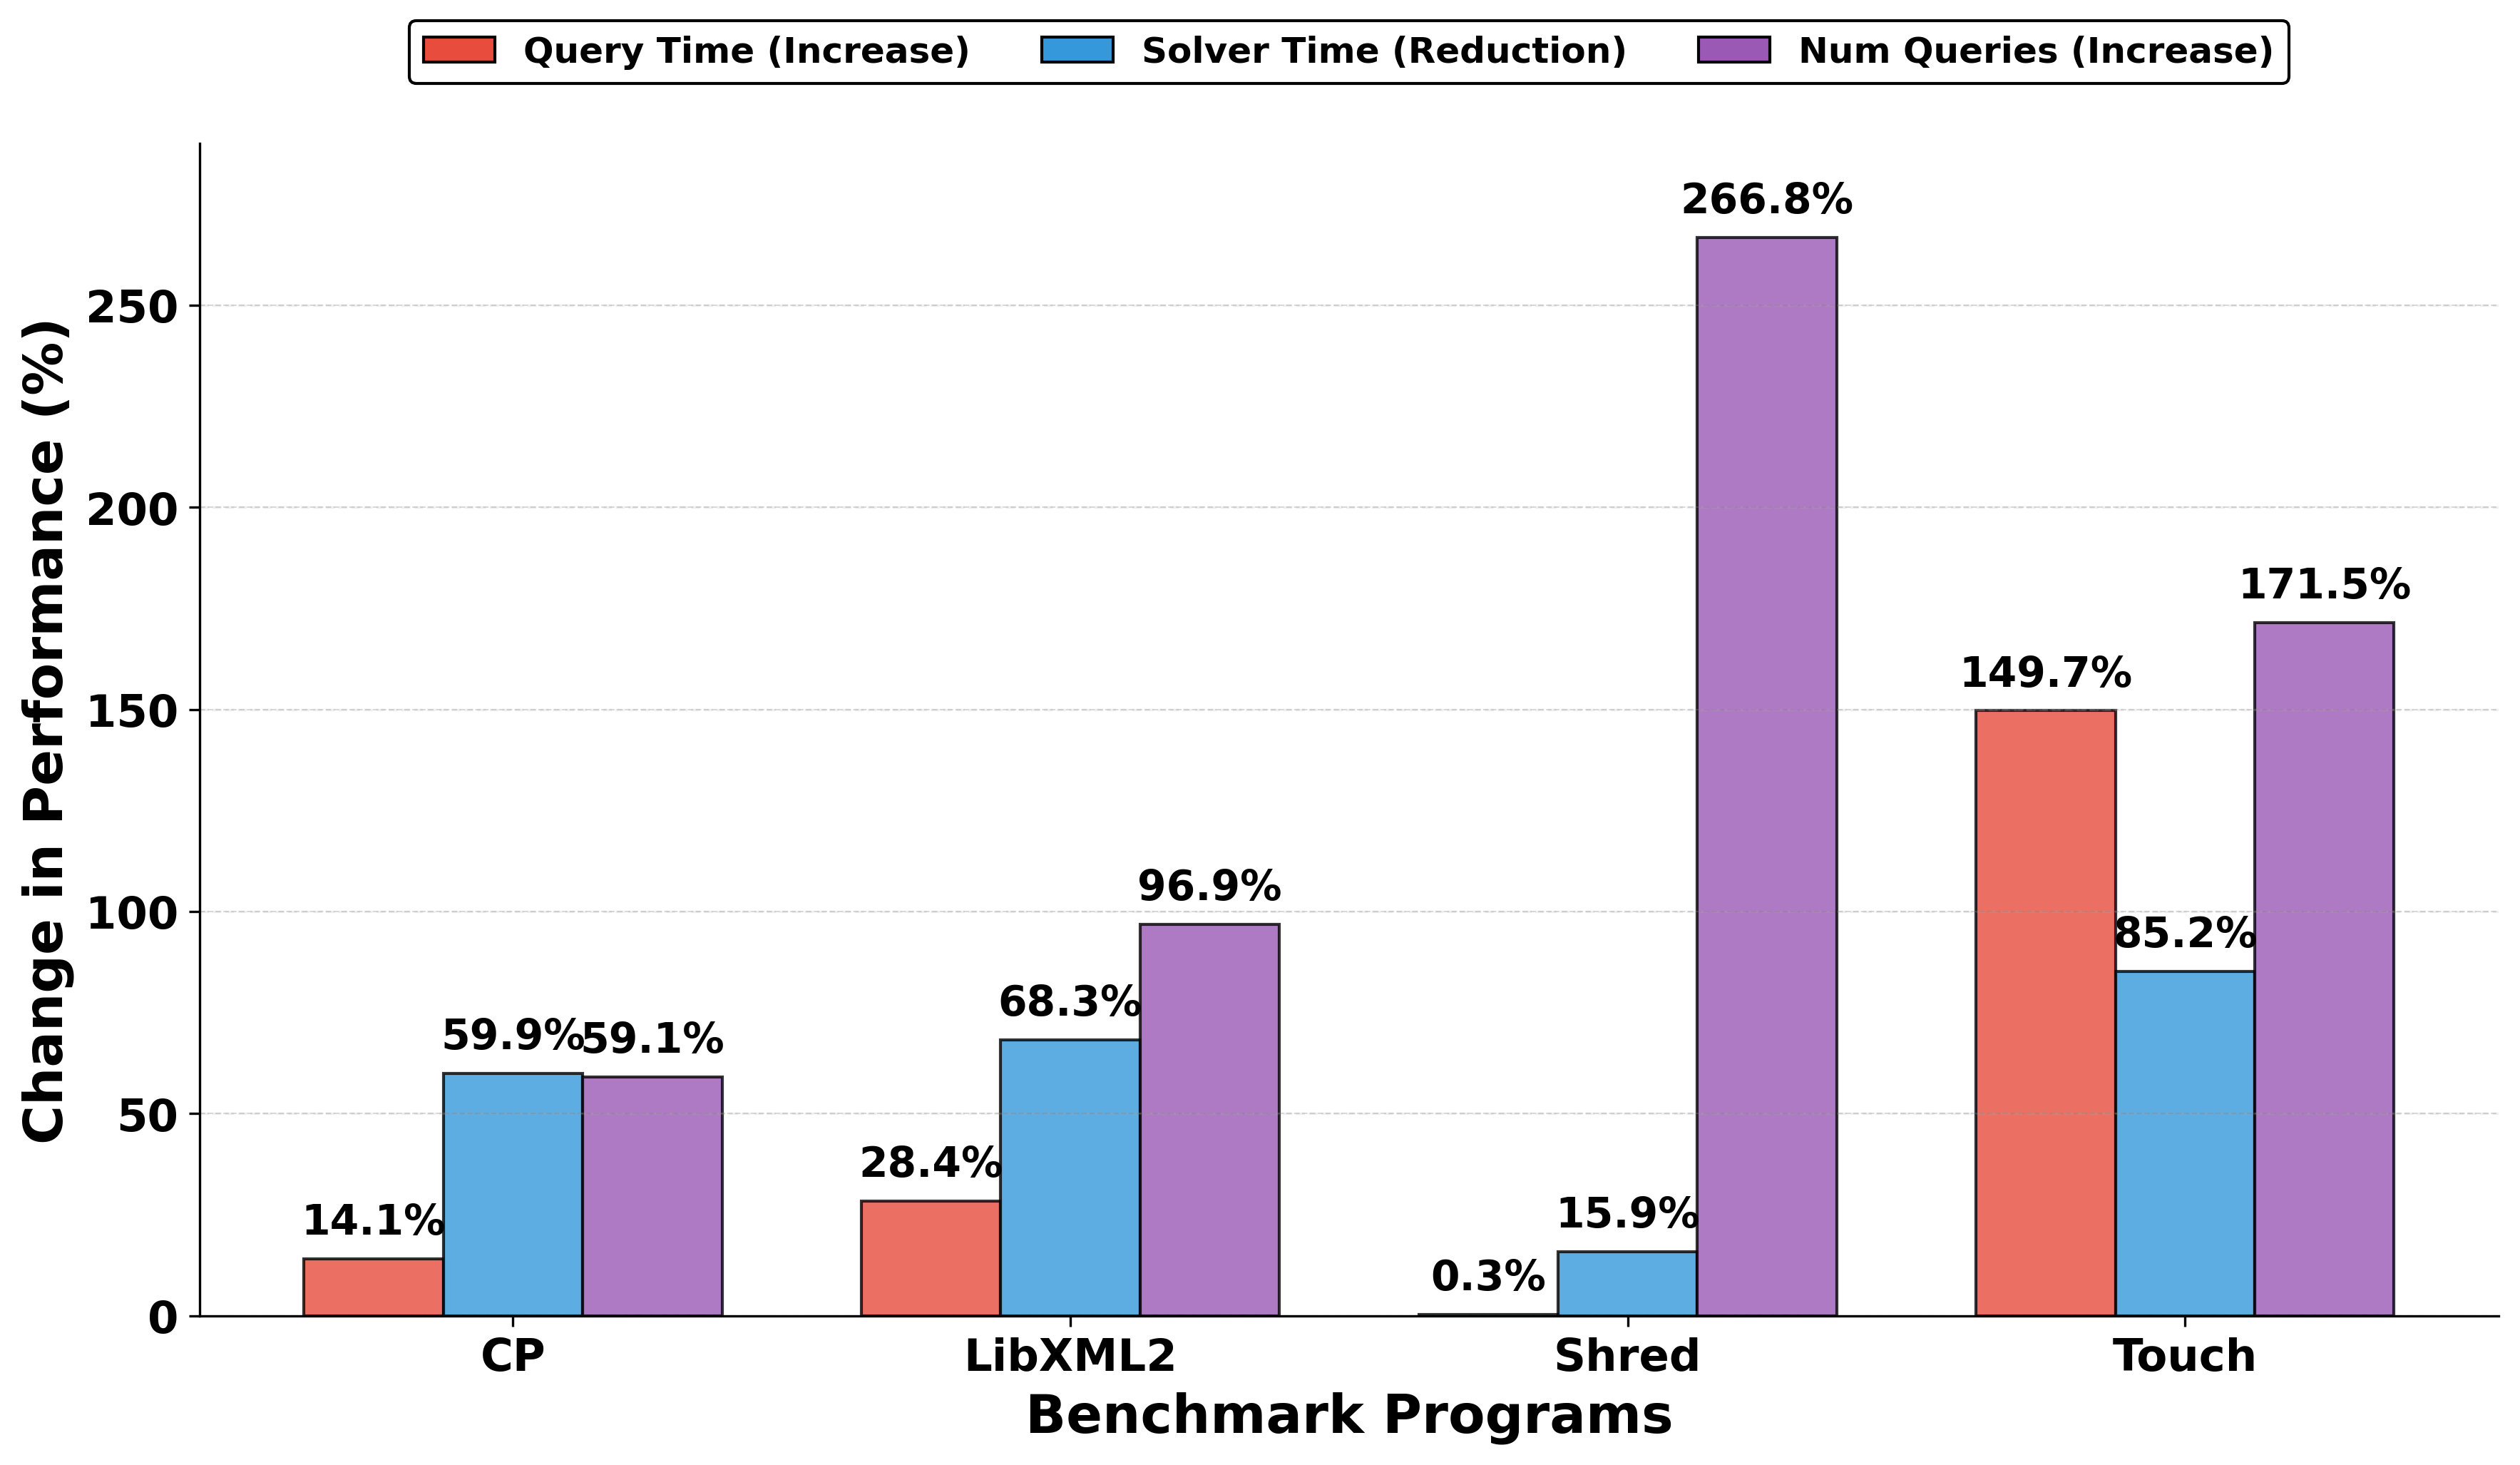


RQ3: PERFORMANCE VARIATION ANALYSIS

CP:
  Query Time: -14.1%
  Solver Time: +59.9%
  Num Queries: -59.1%

LibXML2:
  Query Time: -28.4%
  Solver Time: +68.3%
  Num Queries: -96.9%

Shred:
  Query Time: +0.3%
  Solver Time: +15.9%
  Num Queries: -266.8%

Touch:
  Query Time: -149.7%
  Solver Time: +85.2%
  Num Queries: -171.5%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set publication quality parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 17
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Updated data from your table
programs = ['CP', 'LibXML2', 'Shred', 'Touch']
query_time_change = [-14.1, -28.4, 0.3, -149.7]  # Negative means worse
solver_time_improvement = [59.9, 68.3, 15.9, 85.2]  # Positive is better
num_queries_change = [-59.1, -96.9, -266.8, -171.5]  # Negative means more queries (worse)

# Convert to absolute values for display, but track sign
query_time_abs = np.abs(query_time_change)
queries_abs = np.abs(num_queries_change)

width = 0.25
group_gap = 0.15

# Calculate x positions for each group
x = np.arange(len(programs))

fig, ax = plt.subplots(figsize=(12, 7))

# Define colors - using different colors for each metric
color_query_time = '#E74C3C'    # Red for query time (mostly regressions)
color_solver = '#3498DB'         # Blue for solver (always improved)
color_num_queries = '#9B59B6'    # Purple for number of queries (all increases)
# Alternative color options:
# color_num_queries = '#E67E22'  # Orange
# color_num_queries = '#F39C12'  # Yellow-orange
# color_num_queries = '#8E44AD'  # Dark purple

# Plot bars with appropriate colors
bars1 = []
bars2 = []
bars3 = []

for i in range(len(programs)):
    # Query Time bars (mostly regressions) - RED
    color1 = '#27AE60' if query_time_change[i] > 0 else color_query_time  # Green only for improvements
    bar1 = ax.bar(x[i] - width, query_time_abs[i], width,
                  color=color1, alpha=0.8, edgecolor='black', linewidth=1)
    bars1.append(bar1)

    # Solver Time bars (all improvements) - BLUE
    bar2 = ax.bar(x[i], solver_time_improvement[i], width,
                  color=color_solver, alpha=0.8, edgecolor='black', linewidth=1)
    bars2.append(bar2)

    # Number of Queries bars (all increases) - PURPLE
    bar3 = ax.bar(x[i] + width, queries_abs[i], width,
                  color=color_num_queries, alpha=0.8, edgecolor='black', linewidth=1)
    bars3.append(bar3)

# Function to annotate bars - all text above bars
def annotate_above_bar(bar, value):
    """
    Always place text above the bar
    """
    height = bar[0].get_height()

    # Display value with proper formatting
    display_value = f'{abs(value):.1f}%'

    # Always place text above bar with consistent spacing
    y_pos = height + 4  # Fixed spacing above bar

    # Always use black text with larger font
    ax.text(bar[0].get_x() + bar[0].get_width()/2, y_pos,
            display_value,
            ha='center', va='bottom',
            fontsize=14,  # Increased font size
            fontweight='bold',
            color='black')  # Always black text

# Annotate all bars with text above
for i in range(len(programs)):
    # Query time bars
    annotate_above_bar(bars1[i], query_time_change[i])

    # Solver time bars
    annotate_above_bar(bars2[i], solver_time_improvement[i])

    # Number of queries bars
    annotate_above_bar(bars3[i], num_queries_change[i])

# Setting the axis labels and ticks
ax.set_xlabel('Benchmark Programs', fontsize=18, fontweight='bold')
ax.set_ylabel('Change in Performance (%)', fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(programs, fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')

# Extend y-limit to accommodate text above bars
plt.ylim(0, 290)  # Slightly increased to give space for text above tallest bar

# Create custom legend with clear indicators
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=color_query_time, edgecolor='black', label='Query Time (Increase)'),
    Patch(facecolor=color_solver, edgecolor='black', label='Solver Time (Reduction)'),
    Patch(facecolor=color_num_queries, edgecolor='black', label='Num Queries (Increase)')
]

legend = ax.legend(handles=legend_elements, loc='upper center',
                  bbox_to_anchor=(0.5, 1.12), ncol=3,
                  fontsize=12, framealpha=1, edgecolor='black')

for text in legend.get_texts():
    text.set_fontweight('bold')

# Add horizontal reference lines
for y_val in [50, 100, 150, 200, 250]:
    ax.axhline(y=y_val, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.2)

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.subplots_adjust(top=0.85, bottom=0.15)
plt.tight_layout()

# Save figures
plt.savefig('rq3-performance-variation.pdf', dpi=300, bbox_inches='tight')
plt.savefig('rq3-performance-variation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print basic statistics only
print("\n" + "="*60)
print("RQ3: PERFORMANCE VARIATION ANALYSIS")
print("="*60)

for i, prog in enumerate(programs):
    print(f"\n{prog}:")
    print(f"  Query Time: {query_time_change[i]:+.1f}%")
    print(f"  Solver Time: {solver_time_improvement[i]:+.1f}%")
    print(f"  Num Queries: {num_queries_change[i]:+.1f}%")
